In [194]:
# Импортируем необходимые библиотеки
import pandas as pd  # для работы с данными
import numpy as np  # для числовых операций
from sklearn.metrics.pairwise import cosine_similarity  # для вычисления сходства
from sklearn.cluster import KMeans  # для кластеризации
import folium  # для работы с картами
from geopy.distance import geodesic  # для расчета расстояний
import matplotlib.pyplot as plt  # для визуализации
import seaborn as sns  # для визуализации
from sklearn.metrics import silhouette_score  # для вычисления коэффициента силуэта


In [196]:
data_path = r"C:\Users\User\Documents\geoProject.csv"  #путь к файлу, загружаем датасет 
data = pd.read_csv(data_path)

In [198]:
print("Dataset Info:") #отображение краткой информации датасета
data.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4501 entries, 0 to 4500
Data columns (total 90 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   space_url                                          4501 non-null   object 
 1   venue_url                                          4501 non-null   object 
 2   venue_name                                         4501 non-null   object 
 3   space_name                                         4501 non-null   object 
 4   latitude                                           4501 non-null   float64
 5   longitude                                          4501 non-null   float64
 6   address                                            4501 non-null   object 
 7   nearest_tube_station                               4144 non-null   object 
 8   max_seated                                         4501 non-null   int64  

In [170]:
columns_to_keep = [
    'venue_name', 'latitude', 'longitude', 'max_seated', 'max_standing',    #Оставляем только нужные столбцы
    'Wi-Fi', 'Air conditioning', 'Parking available', 'nearest_tube_station'
]
data = data[columns_to_keep].dropna(subset=['latitude', 'longitude', 'venue_name']) #убираем строки с пропущенными значениями в столбцах 'latitude', 'longitude', 'venue_name'
bool_columns = ['Wi-Fi', 'Air conditioning', 'Parking available'] #булевые значения в тип bool
data[bool_columns] = data[bool_columns].astype(bool) #mun bool
data[bool_columns] = data[bool_columns].fillna(False) #заполнение пропущенных значений False 

for col in bool_columns: #буловые значения в 1 и 0
    data[col] = data[col].map({True: 1, False: 0})

In [172]:
data.head()  # первые строки

,venue_name,latitude,longitude,max_seated,max_standing,Wi-Fi,Air conditioning,Parking available,nearest_tube_station
0,techspace aldgate east,51.514050,-0.070852,2,0,1,0,0,Aldgate East Station (200 yd)
1,green rooms hotel,51.597050,-0.110910,88,120,1,0,1,Wood Green Station (150 yd)
2,148 leadenhall street,51.513470,-0.083224,10,0,1,1,0,Bank Station (450 yd)
3,conway hall,51.519792,-0.118337,60,60,1,0,0,Holborn Station (350 yd)
4,whyte & brown,51.512505,-0.138641,40,50,1,0,0,Oxford Circus Station (400 yd)


In [176]:
data.tail()  # последние строки

,venue_name,latitude,longitude,max_seated,max_standing,Wi-Fi,Air conditioning,Parking available,nearest_tube_station
4496,science museum,51.497870,-0.174515,400,0,1,0,0,South Kensington Station (500 yd)
4497,the buckle factory,51.579980,-0.078470,0,60,1,0,0,Seven Sisters Station (650 yd)
4498,hilton london paddington,51.515780,-0.175524,8,0,1,1,1,Paddington Station (100 yd)
4499,the abbey tap,51.540274,0.000392,50,250,1,1,0,Stratford Station (300 yd)
4500,aquavit london,51.508863,-0.133215,63,100,1,1,0,Piccadilly Circus Station (200 yd)


In [178]:
def calculate_distance(user_coords, place_coords):         #расчет расстояния между двумя точками
    return geodesic(user_coords, place_coords).kilometers

user_location = (51.509865, -0.118092) 
data['distance'] = data.apply(         #добавление столбца с растоянием от пользователя до каждого места
    lambda row: calculate_distance(user_location, (row['latitude'], row['longitude'])), axis=1
)

radius_km = 50    #фильтрация мест в радиусе 50км
filtered_data = data[data['distance'] <= radius_km]

In [180]:
features = ['max_seated', 'max_standing', 'Wi-Fi', 'Air conditioning']   ##подготовка данных для рекомендации

filtered_data[features] = filtered_data[features].fillna(0)  #нормализация числовых признаков для вычисления сходства
filtered_data_normalized = (filtered_data[features] - filtered_data[features].min()) / (
    filtered_data[features].max() - filtered_data[features].min()
)

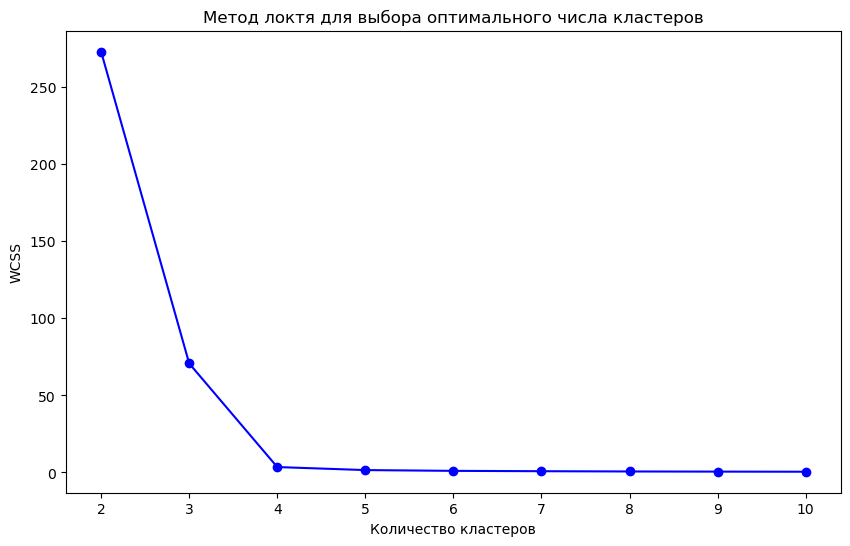

In [182]:
from sklearn.cluster import KMeans   #для кластеризации
import matplotlib.pyplot as plt    #визуализация графика
from sklearn.metrics import silhouette_score       #cилуэтный коэфициент
from sklearn.impute import SimpleImputer  #обработка пропущенных значений 
imputer = SimpleImputer(strategy='mean')     #замена пропущенных значений 
filtered_data_normalized_imputed = imputer.fit_transform(filtered_data_normalized)  #замена всех NaN на средние значения

wcss = []    #метод локтя
for i in range(2, 11):  # Проверяем количество кластеров от 2 до 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(filtered_data_normalized_imputed)
    wcss.append(kmeans.inertia_)  #WCSS для текущего числа кластеров

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o', color='blue')
plt.title('Метод локтя для выбора оптимального числа кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

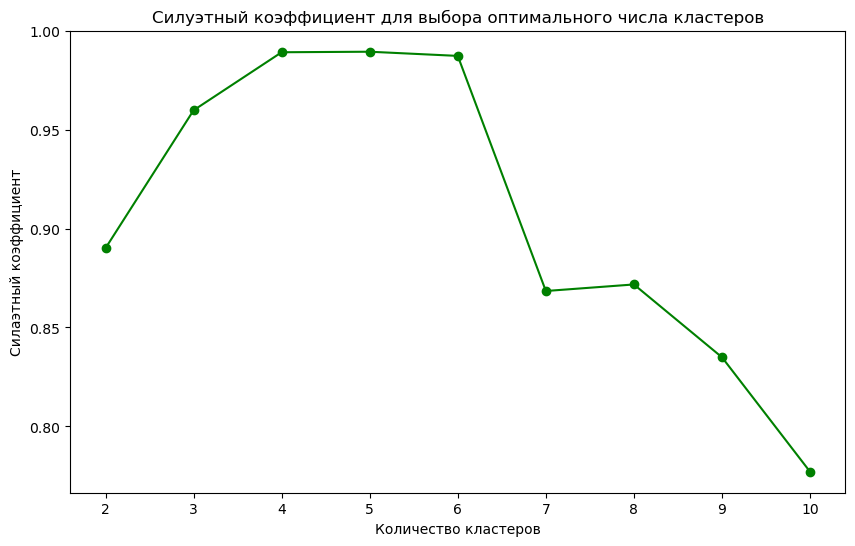

Оптимальное количество кластеров: 5


In [183]:
import matplotlib.pyplot as plt    #визуализация графика
from sklearn.metrics import silhouette_score       #cилуэтный коэфициент

silhouette_scores = []   #вычисление силуэтного коэффициента для каждого количества кластеров
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(filtered_data_normalized_imputed)
    score = silhouette_score(filtered_data_normalized_imputed, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))    #визуализизация силуэтного коэффициента для разных чисел кластеров
plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
plt.title('Силуэтный коэффициент для выбора оптимального числа кластеров')
plt.xlabel('Количество кластеров')
plt.ylabel('Силаэтный коэффициент')
plt.show()
optimal_clusters = range(2, 11)[silhouette_scores.index(max(silhouette_scores))] #вычисление оптимального числа кластеров на основе максимального значения с.k
print(f"Оптимальное количество кластеров: {optimal_clusters}")

In [142]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import pandas as pd

imputer = SimpleImputer(strategy='mean')   #Импретируем пропущенные значения с использованием стратегии 'mean' (среднее значение)
filtered_data_normalized_imputed = imputer.fit_transform(filtered_data_normalized)

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)   #применяем кластеризацию с оптимальным числом кластеров
filtered_data['cluster'] = kmeans.fit_predict(filtered_data_normalized_imputed)

In [184]:
filtered_data.head(10)  #вывод первых строк с результатами кластеризации

,venue_name,latitude,longitude,max_seated,max_standing,Wi-Fi,Air conditioning,Parking available,nearest_tube_station,distance
0,techspace aldgate east,51.514050,-0.070852,2,0,1,0,0,Aldgate East Station (200 yd),3.312385
1,green rooms hotel,51.597050,-0.110910,88,120,1,0,1,Wood Green Station (150 yd),9.712921
2,148 leadenhall street,51.513470,-0.083224,10,0,1,1,0,Bank Station (450 yd),2.453619
3,conway hall,51.519792,-0.118337,60,60,1,0,0,Holborn Station (350 yd),1.104624
4,whyte & brown,51.512505,-0.138641,40,50,1,0,0,Oxford Circus Station (400 yd),1.456490
5,gridiron building,51.532234,-0.125479,12,0,1,1,0,King's Cross St. Pancras Station (300 yd),2.540981
6,sandown park racecourse,51.372826,-0.360293,420,420,1,1,1,NaN,22.716621
7,duke of edinburgh,51.463222,-0.119974,0,500,1,0,1,Brixton Station (450 yd),5.191027
8,kimpton fitzroy london,51.522738,-0.124498,6,0,1,1,1,Russell Square Station (50 yd),1.499618
9,magazine london,51.501066,-0.000837,900,1750,1,1,0,North Greenwich Station (400 yd),8.199931


In [186]:
m = folium.Map(location=user_location, zoom_start=12)  ##визуализация на карте
for _, row in filtered_data.iterrows(): ##добавляем маркеры для каждого места на карту
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['venue_name']} ({row['distance']:.2f} km)",
        icon=folium.Icon(color='blue')
    ).add_to(m)

In [150]:
from IPython.display import display
#print("Interactive Map:")
#display(m)
m.save('map.html')

In [151]:
import webbrowser 
webbrowser.open('map.html') #открытие файла в браузере

True

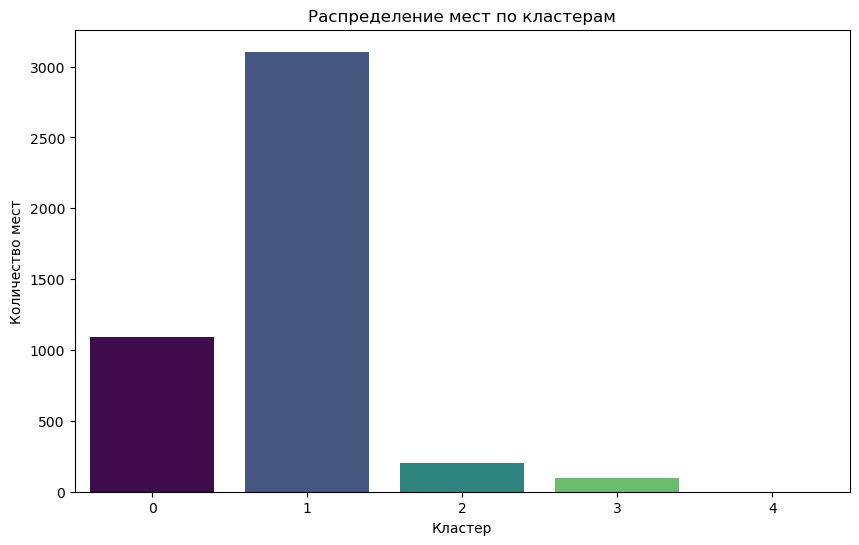

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=filtered_data, hue='cluster', palette='viridis', legend=False)
plt.title('Распределение мест по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Количество мест')
plt.show()

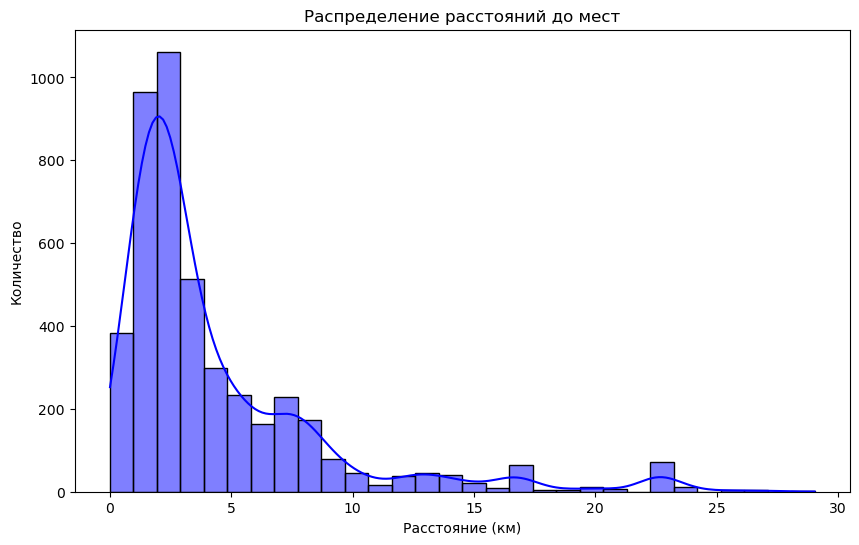

In [156]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['distance'], kde=True, bins=30, color='blue')
plt.title('Распределение расстояний до мест')
plt.xlabel('Расстояние (км)')
plt.ylabel('Количество')
plt.show()

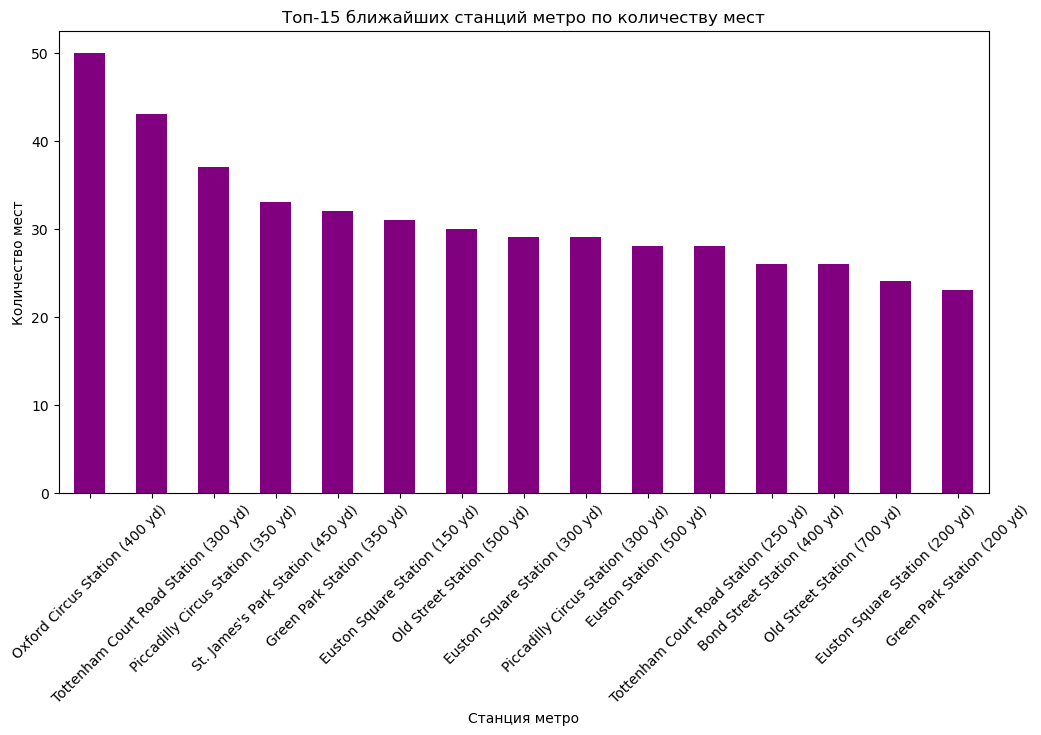

In [158]:
top_10_tube_stations = filtered_data['nearest_tube_station'].value_counts().head(15)
plt.figure(figsize=(12, 6))
top_10_tube_stations.plot(kind='bar', color='purple')
plt.title('Топ-15 ближайших станций метро по количеству мест')
plt.xlabel('Станция метро')
plt.ylabel('Количество мест')
plt.xticks(rotation=45)
plt.show()

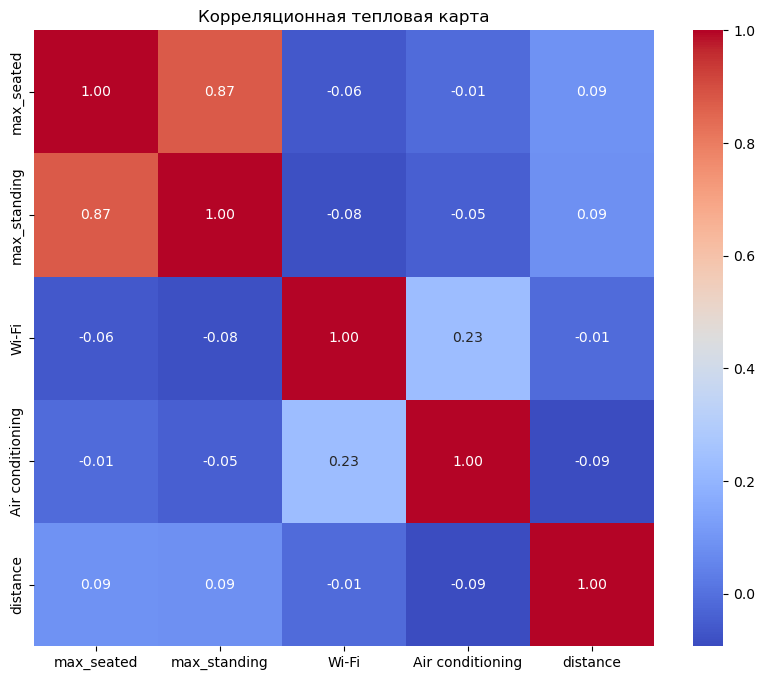

In [160]:
# Корреляционная тепловая карта для числовых признаков
plt.figure(figsize=(10, 8))
correlation_matrix = filtered_data[features + ['distance']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная тепловая карта')
plt.show()

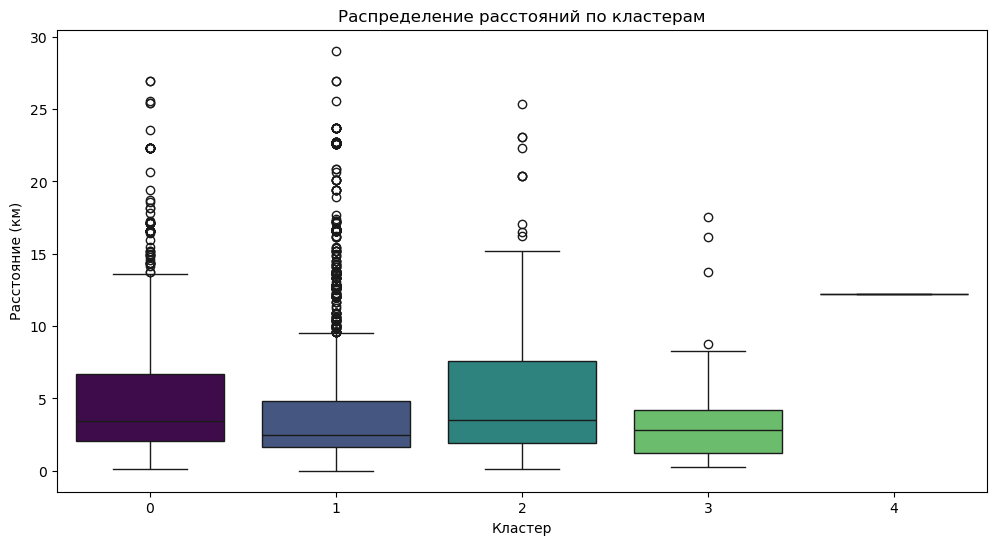

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='distance', data=filtered_data, hue='cluster', palette='viridis', legend=False)
plt.title('Распределение расстояний по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Расстояние (км)')
plt.show()